## Titanic Kaggle Submission

In [ ]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
!pip install catboost
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 66.2MB 56kB/s 


In [ ]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [ ]:
# View the training data (Notice the training has a column "Survived")
train.head(15)

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0             1         0       3  ...   7.2500   NaN         S
1             2         1       1  ...  71.2833   C85         C
2             3         1       3  ...   7.9250   NaN         S
3             4         1       1  ...  53.1000  C123         S
4             5         0       3  ...   8.0500   NaN         S
5             6         0       3  ...   8.4583   NaN         Q
6             7         0       1  ...  51.8625   E46         S
7             8         0       3  ...  21.0750   NaN         S
8             9         1       3  ...  11.1333   NaN         S
9            10         1       2  ...  30.0708   NaN         C
10           11         1       3  ...  16.7000    G6         S
11           12         1       1  ...  26.5500  C103         S
12           13         0       3  ...   8.0500   NaN         S
13           14         0       3  ...  31.2750   NaN         S
14           15         0       3  ...   7.8542   NaN         S

[15 rows x 12 columns]

In [ ]:
# View the test data
test.head(15) 

PassengerId  Pclass  ... Cabin Embarked
0           892       3  ...   NaN        Q
1           893       3  ...   NaN        S
2           894       2  ...   NaN        Q
3           895       3  ...   NaN        S
4           896       3  ...   NaN        S
5           897       3  ...   NaN        S
6           898       3  ...   NaN        Q
7           899       2  ...   NaN        S
8           900       3  ...   NaN        C
9           901       3  ...   NaN        S
10          902       3  ...   NaN        S
11          903       1  ...   NaN        S
12          904       1  ...   B45        S
13          905       2  ...   NaN        S
14          906       1  ...   E31        S

[15 rows x 11 columns]

In [ ]:
# View the submisison dataframe
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [ ]:
## Data descriptions

#Survival: 0 = No, 1 = Yes
#pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd
#sex: Sex
#Age: Age in years
#sibsp: number of siblings/spouses aboard the Titanic
#parch: number of parents/children aboard the Titanic
#ticket: Ticket number
#fare: Passenger fare
#cabin: Cabin number
#embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
#Describe the data set
train.describe()

PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071  ...    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]

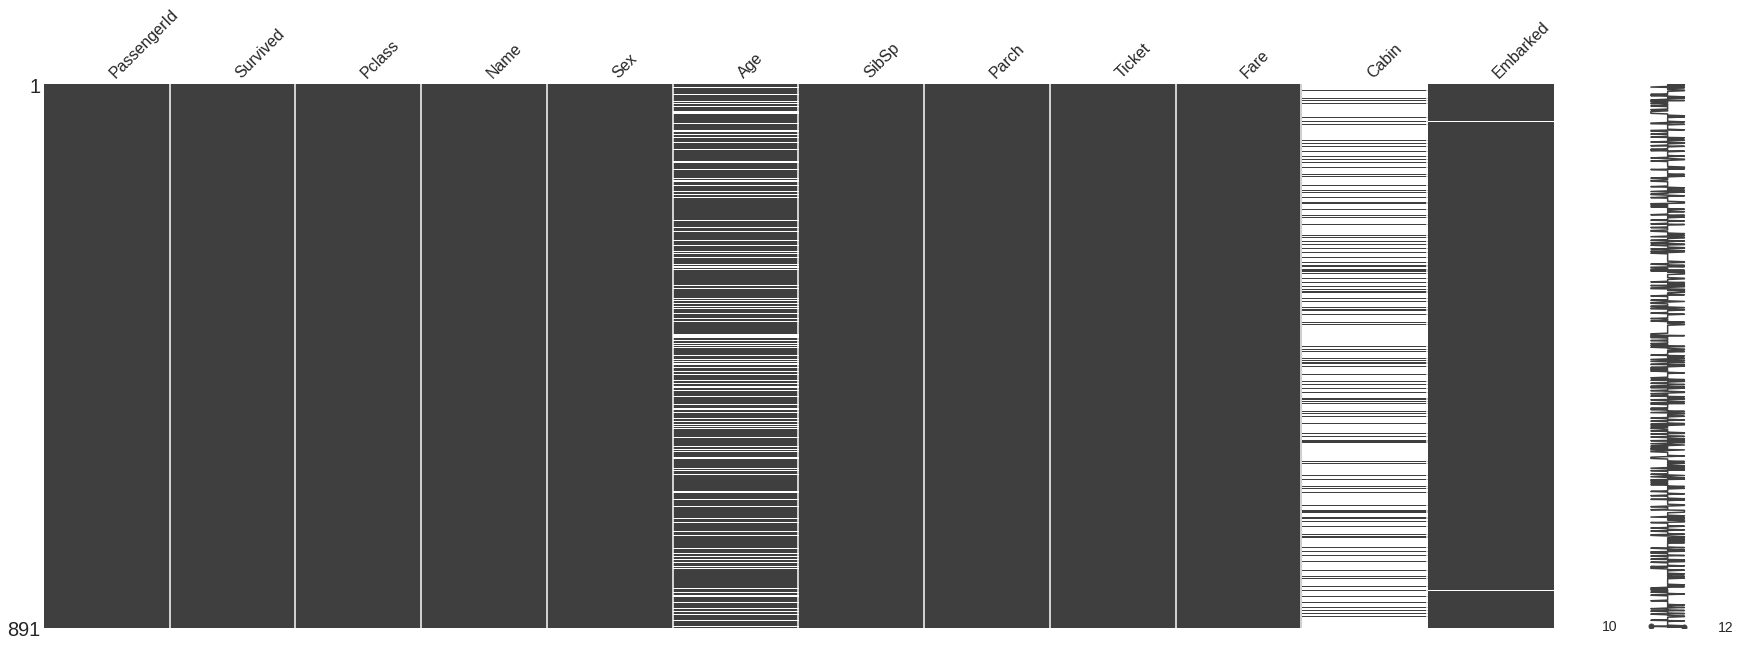

In [ ]:
# Plot missing values graphically
missingno.matrix(train, figsize = (30,10))

In [ ]:
# The exact number of values missing 
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# for discretised continuous variables (batched(bucketed)continuous variables ( 0-10;10-20;20-30:ect ))
df_bin = pd.DataFrame()
# for continuous variables ( 0 - 100)
df_con = pd.DataFrame()

In [ ]:
# Different data types in the dataset
train.dtypes



PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Lets explore the features individually 
We will go through each column iteratively and see which ones to use in our model

In [ ]:
train.head()

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

In [ ]:
#Function to create count and distribution visualisations
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

#Feature: Survived
Key: 0 = did not survive, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


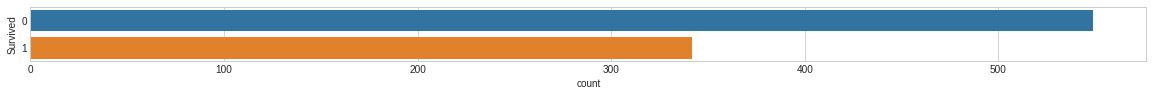

In [ ]:
# Whats your target feature "Survived"
# Key: 0 = did not survive, 1 = survived
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [ ]:
# Let's add "Survived" to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']



#Feature: P Class
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

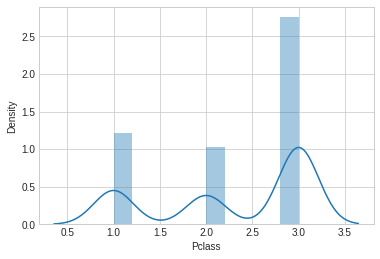

In [ ]:
#Plot the distribution
sns.distplot(train.Pclass)

In [ ]:
#How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [ ]:
#Let's add "P Class" to our subset dataframes
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

#Feature: Name
Description: The name of the passenger.

In [ ]:
#How many different names are there?
train.Name.value_counts()

Kantor, Mrs. Sinai (Miriam Sternin)              1
Woolner, Mr. Hugh                                1
Harris, Mr. Henry Birkhardt                      1
Lefebre, Miss. Ida                               1
Dahlberg, Miss. Gerda Ulrika                     1
                                                ..
Smith, Mr. Richard William                       1
Crosby, Miss. Harriet R                          1
Sutehall, Mr. Henry Jr                           1
Hansen, Mr. Henrik Juul                          1
Appleton, Mrs. Edward Dale (Charlotte Lamson)    1
Name: Name, Length: 891, dtype: int64

#Feature: Sex
Description: The sex of the passenger (male or female).

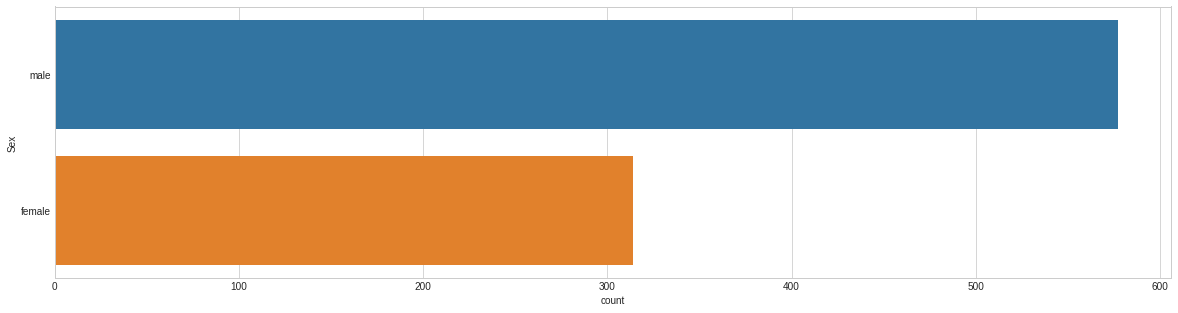

In [ ]:
#Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [ ]:
#Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

In [ ]:
#add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']



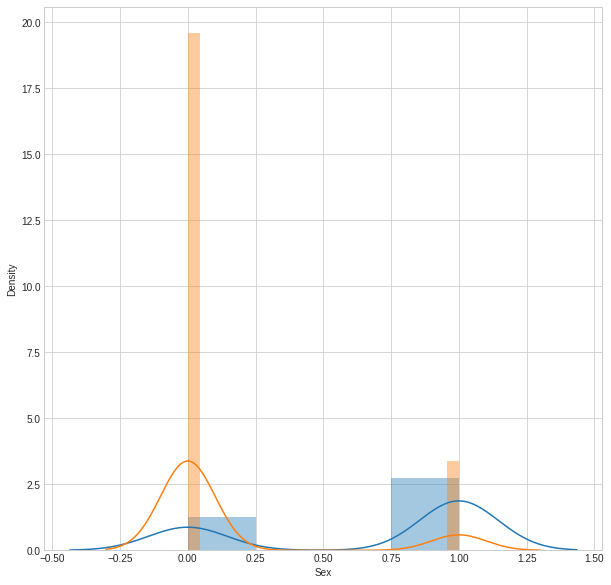

In [ ]:
#Sex feature vs Survived feature
#We can see this because they're both binarys can be applied to any binaries
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

#Feature: Age
The passangers age

In [ ]:
#How many missing values does age have?
train.Age.isnull().sum()

177

In [ ]:
#To many missing to look at in our early predictions

#Feature: SibSp
Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [ ]:
#How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [ ]:
#Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

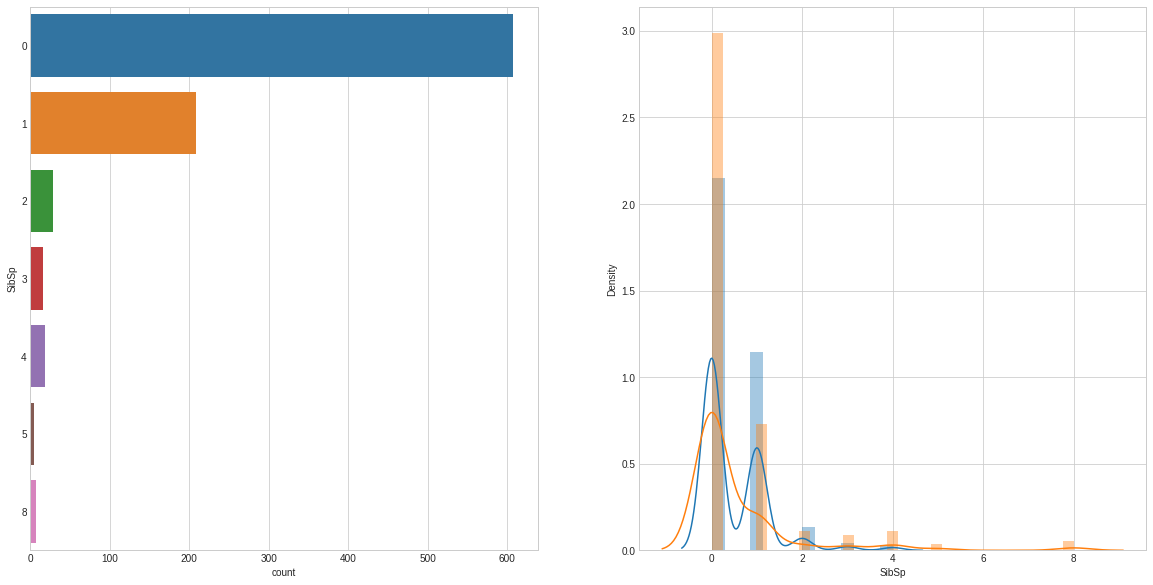

In [ ]:
#Visualise the counts of SibSp and the distribution of the values against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

#Feature: Parch
Description: The number of parents/children the passenger has

In [ ]:
#How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [ ]:
#What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [ ]:
#Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

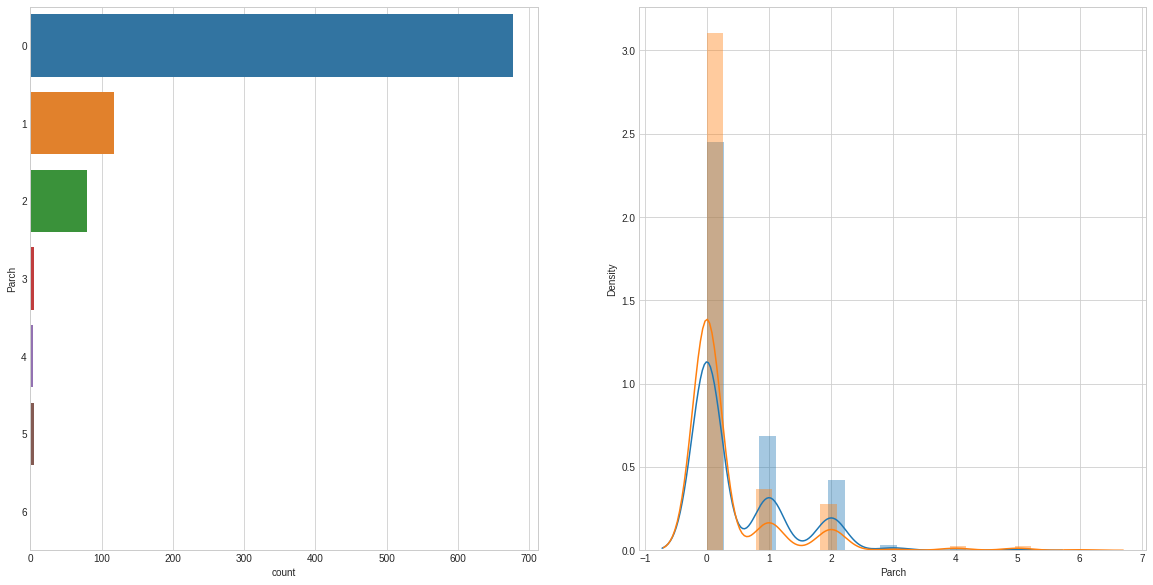

In [ ]:
# Visualise the counts of Parch and the distribution of the values against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

#Feature: Ticket
Description: The ticket number of the boarding passenger

In [ ]:
#How many missing values does Ticket have?
train.Ticket.isnull().sum()


0

In [ ]:
#How many kinds of ticket are there?
train.Ticket.value_counts()

CA. 2343    7
347082      7
1601        7
347088      6
3101295     6
           ..
370372      1
28228       1
2693        1
113800      1
2677        1
Name: Ticket, Length: 681, dtype: int64

In [ ]:
#How many unique kinds of Ticket are there?
print("There are {} unique Tickets.".format(len(train.Ticket.unique())))

There are 681 unique Tickets.


#Feature: Fare
Description: How much the ticket cost

In [ ]:
#How many missing values does Fare have?
train.Fare.isnull().sum()

0

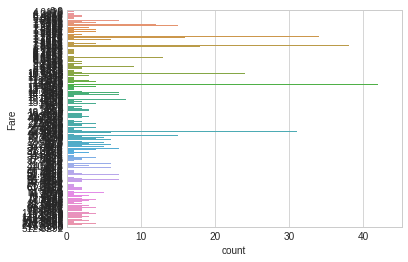

In [ ]:
#How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [ ]:
#What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [ ]:
#How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


In [ ]:
# Add Fare to sub dataframes as its a Float
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

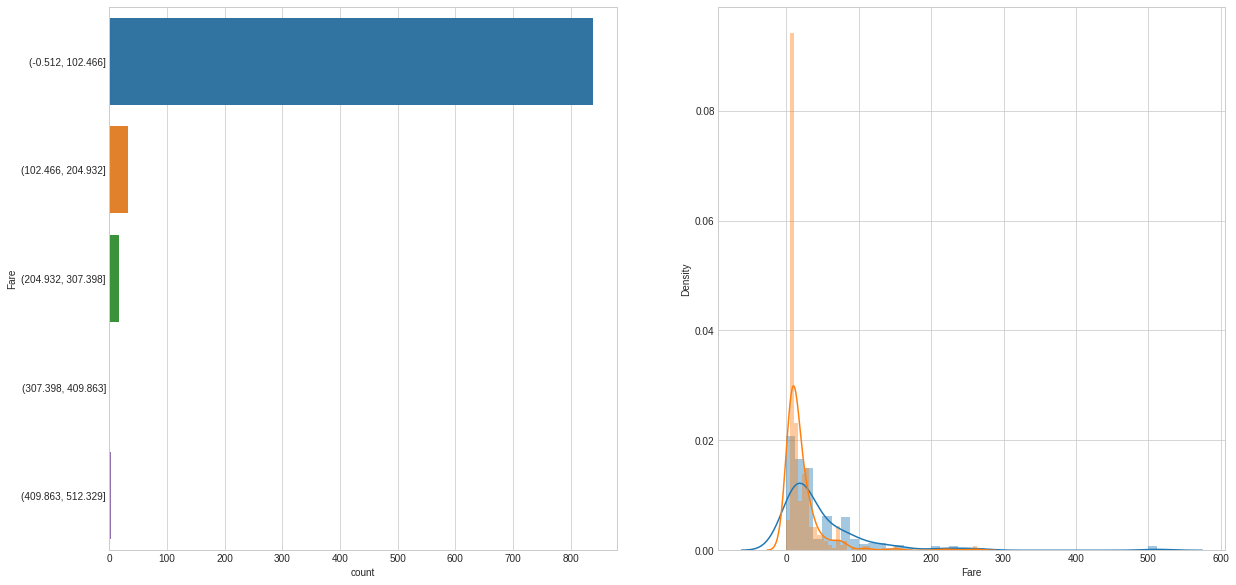

In [ ]:
#Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

#Feature: Cabin
Description: The cabin number where the passenger was staying

In [ ]:
#How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [ ]:
#To many missing values to use Cabin at the moment

#Feature: Embarked
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
#How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [ ]:
#What kind of values do you have
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

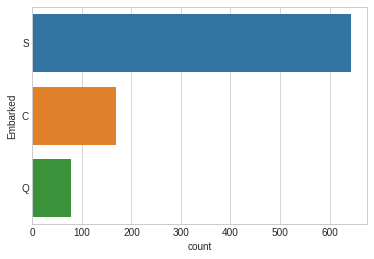

In [ ]:
#What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [ ]:
#Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [ ]:
#Remove Embarked rows which have missing values
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])


##Now for Feature Encoding

In [ ]:
#Look at your df
df_bin.head()

Survived  Pclass  Sex  SibSp  Parch               Fare Embarked
0         0       3    0      1      0  (-0.512, 102.466]        S
1         1       1    1      1      0  (-0.512, 102.466]        C
2         1       3    1      0      0  (-0.512, 102.466]        S
3         1       1    1      1      0  (-0.512, 102.466]        S
4         0       3    0      0      0  (-0.512, 102.466]        S

In [ ]:
#One-hot encode the binned variables
#One-hot encoding gives a 0 for what is isnt and a 1 for what it is
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

Survived  Pclass_1  Pclass_2  ...  Embarked_C  Embarked_Q  Embarked_S
0         0         0         0  ...           0           0           1
1         1         1         0  ...           1           0           0
2         1         0         0  ...           0           0           1
3         1         1         0  ...           0           0           1
4         0         0         0  ...           0           0           1

[5 rows x 28 columns]

In [ ]:
#One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')



In [ ]:
#Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

#Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1 )

## Building the Machine Learning Model

Seperate the data 

In [ ]:
#Select the dataframe you want to use
selected_df = df_con_enc

In [ ]:
selected_df.head()

Survived  SibSp  Parch     Fare  ...  sex_male  pclass_1  pclass_2  pclass_3
0         0      1      0   7.2500  ...         1         0         0         1
1         1      1      0  71.2833  ...         0         1         0         0
2         1      0      0   7.9250  ...         0         0         0         1
3         1      1      0  53.1000  ...         0         1         0         0
4         0      0      0   8.0500  ...         1         0         0         1

[5 rows x 12 columns]

In [ ]:
#Split the dataframe into Data and Labels
X_train = selected_df.drop('Survived', axis=1) # x variable (data)
y_train = selected_df.Survived # y variable (labels)

In [ ]:
#Shape of the data (without labels)
X_train.shape

(889, 11)

In [ ]:
X_train.head()

SibSp  Parch     Fare  embarked_C  ...  sex_male  pclass_1  pclass_2  pclass_3
0      1      0   7.2500           0  ...         1         0         0         1
1      1      0  71.2833           1  ...         0         1         0         0
2      0      0   7.9250           0  ...         0         0         0         1
3      1      0  53.1000           0  ...         0         1         0         0
4      0      0   8.0500           0  ...         1         0         0         1

[5 rows x 11 columns]

In [ ]:
# Shape of the labels
y_train.shape

(889,)

Find machine learning algorithms

In [ ]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

#Logistic Regression

In [ ]:
#Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:01.569888


#K-Nearest Neighbours

In [ ]:
#k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.147279


#Gaussian Naive Bayes

In [ ]:
#Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.064498


#Linear Support Vector Machines (SVC)

In [ ]:
#Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.4
Accuracy CV 10-Fold: 75.59
Running Time: 0:00:00.375647


#Stochastic Gradient Descent

In [ ]:
#Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 75.59
Accuracy CV 10-Fold: 68.73
Running Time: 0:00:00.101089


#Decision Tree Classifier

In [ ]:
#Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.2
Running Time: 0:00:00.091516


#Gradient Boost Trees

In [ ]:
#Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:00.981117


#CatBoost Algorithm
CatBoost uses gradient boosting on decision trees 

In [ ]:
#View the data for the CatBoost model
X_train.head()

SibSp  Parch     Fare  embarked_C  ...  sex_male  pclass_1  pclass_2  pclass_3
0      1      0   7.2500           0  ...         1         0         0         1
1      1      0  71.2833           1  ...         0         1         0         0
2      0      0   7.9250           0  ...         0         0         0         1
3      1      0  53.1000           0  ...         0         1         0         0
4      0      0   8.0500           0  ...         1         0         0         1

[5 rows x 11 columns]

In [ ]:
#View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [ ]:
#Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
#Use the CatBoost function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [ ]:
#CatBoost model definition
#Classification = 0 or 1
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

#Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

#CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.009797


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6862830	total: 57.8ms	remaining: 57.7s
1:	learn: 0.6809444	total: 60.7ms	remaining: 30.3s
2:	learn: 0.6751692	total: 65.1ms	remaining: 21.6s
3:	learn: 0.6689060	total: 69.1ms	remaining: 17.2s
4:	learn: 0.6632144	total: 72.9ms	remaining: 14.5s
5:	learn: 0.6576488	total: 75.8ms	remaining: 12.6s
6:	learn: 0.6544441	total: 77.2ms	remaining: 10.9s
7:	learn: 0.6490635	total: 81.2ms	remaining: 10.1s
8:	learn: 0.6443241	total: 93.8ms	remaining: 10.3s
9:	learn: 0.6395935	total: 99ms	remaining: 9.8s
10:	learn: 0.6345186	total: 103ms	remaining: 9.3s
11:	learn: 0.6305316	total: 108ms	remaining: 8.87s
12:	learn: 0.6275610	total: 109ms	remaining: 8.27s
13:	learn: 0.6225020	total: 117ms	remaining: 8.21s
14:	learn: 0.6179503	total: 122ms	remaining: 8.01s
15:	learn: 0.6140480	total: 124ms	remaining: 7.64s
16:	learn: 0.6100034	total: 127ms	remaining: 7.36s
17:	learn: 0.6049646	total: 133ms	remaining: 7.23s
18:	learn: 0.6025760	total: 135ms	remaining: 6.97s
19:	learn: 0.5998630	total: 137ms	r

#Perform CatBoost cross-validation

In [ ]:
#How long will this take?
start_time = time.time()

#Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

#Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

#How long did it take?
catboost_time = (time.time() - start_time)

#CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)	total: 335ms	remaining: 5m 34s
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 674ms	remaining: 5m 36s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)	total: 966ms	remaining: 5m 20s
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)	total: 1.26s	remaining: 5m 14s
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)	total: 1.55s	remaining: 5m 8s
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)	total: 1.84s	remaining: 5m 5s
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)	total: 2.14s	remaining: 5m 3s
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)	total: 2.43s	remaining: 5m 1s
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)	total: 2.73s	remaining: 5m
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)	total: 3.02s	remaining: 4m 58s
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)	total: 3.33s	remaining: 4m 59s
11:	learn: 0.5447302	test: 0.5517930	best: 0.5517

In [ ]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:05:31.902858


#Model Results
Which model has the best performace on Regular and Cross-validation

In [ ]:
#Regular
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


Model  Score
5               Decision Tree  92.46
6     Gradient Boosting Trees  86.61
7                    CatBoost  83.91
0                         KNN  83.46
1         Logistic Regression  79.98
2                 Naive Bayes  78.52
4                  Linear SVC  78.40
3  Stochastic Gradient Decent  75.59

In [ ]:
#Cross-validation
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


Model  Score
7                    CatBoost  81.32
6     Gradient Boosting Trees  80.65
5               Decision Tree  80.20
1         Logistic Regression  79.42
2                 Naive Bayes  77.95
0                         KNN  76.72
4                  Linear SVC  75.59
3  Stochastic Gradient Decent  68.73

#Feature importance
Using the Catboost model,which features of the best model were most important for making predictions?

In [ ]:
#Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

imp         col
4    0.992061  embarked_Q
3    1.213711  embarked_C
5    1.677219  embarked_S
9    2.178083    pclass_2
8    3.243021    pclass_1
0   10.797435       SibSp
10  11.205450    pclass_3
1   13.988886       Parch
2   15.753218        Fare
6   17.695520  sex_female
7   21.255397    sex_male

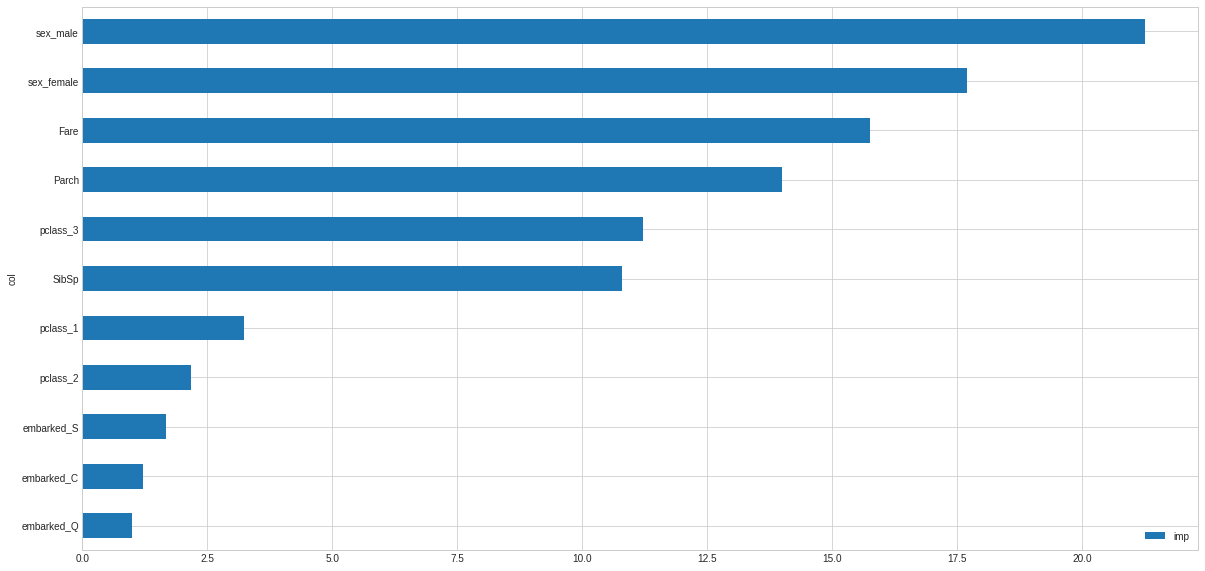

In [ ]:
#Plot the feature importance scores
feature_importance(catboost_model, X_train)

#Precision or Recall

Recall = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

Precision = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an F1 score.

These metrics will all fall between 0 and 1, with a higher value being better.

In [ ]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


#Submission

The columns in test will have to be converted to the same format at df_con_enc.

In [ ]:
#We need our test dataframe to look like this one
X_train.head()

In [ ]:
#Our test dataframe has some columns our model hasn't been trained on
test.head()

In [ ]:
#One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [ ]:
#Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [ ]:
#Let's look at test, it should have one hot encoded columns now
test.head()

The columns in test have been converted to the same format at df_con_enc. Now we can make predictions on the test dataframe columns we built a model on.

We can find the columns we made predictions on with X_train.columns.

In [ ]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [ ]:
#Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [ ]:
#Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [ ]:
#Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()



PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [ ]:
#What does our submission have to look like?
gender_submission.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

We need our submission dataframe to look like the gender_submisison dataframe, so we'll turn the Survived column into integers.

In [ ]:
#Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [ ]:
#How does our submission dataframe look?
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [ ]:
 Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Object `length` not found.
Submission dataframe is the same length as test (418 rows).


In [ ]:
#Convert submisison dataframe to csv for submission to csv 
#for Kaggle submisison
submission.to_csv('../home', index=False)
print('Submission CSV is ready!')

IsADirectoryError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../data")
submissions_check.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1